# ORDINARY KRIGING IN PYTHON - 1D Application

*This Notebook is based on an original Post from Connor Johnson, the original post is found here:
http://connor-johnson.com/2014/03/20/simple-kriging-in-python/. It has been transferred to a Jupyter Notebook to make it more interactive.*

*Changes being made:*
+ *using a common variogram function*
+ *calculation of variance map* 
+ *some code structure*

*The example data is modified to represent a quasi-1D distribution (along the x-axis), to improve comprehensibility. Visualisation has been changed to consider this, and puts an additional focus on the uncertainty of the prediction*

In this post I will work through an example of Simple Kriging. Kriging is a set of techniques for interpolation. It differs from other interpolation techniques in that it sacrifices smoothness for the integrity of sampled points. Most interpolation techniques will over or undershoot the value of the function at sampled locations, but kriging honors those measurements and keeps them fixed. In future posts I would like to cover other types of kriging, other semivariaogram models, and colocated co-kriging. Until then, I’m keeping relatively up to date code at my GitHub project, geostatsmodels. (https://github.com/cjohnson318/geostatsmodels)

In [1]:
from pylab import *
import numpy as np
from pandas import DataFrame, Series
from scipy.spatial.distance import pdist, squareform
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [16 / 1.5, 10 / 1.5]   # inch / cm = 2.54
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
# plt.rcParams['savefig.frameon'] = False

## Data

The data used in this exercise is in a zip file at this site. (Click on Geostatistics Resources.) I have adapted my material from the Kriging document on the same site. My approach will focus more on programming. First we will import some modules and then load the data and parse it,

In [2]:
zraw = open( 'WGTutorial/ZoneA.dat','r' ).readlines()
zraw = [ i.strip().split() for i in zraw[10:] ]
zraw = np.array( zraw, dtype=np.float )
zraw = DataFrame( zraw, columns=['x','y','thk','por','perm','lperm','lpermp','lpermr'] )

For this exercise, we need to reduce the data, and only choose values within a certain intervall for y, and create a quasi-1D Dataset by zeroing the y-coordinate.

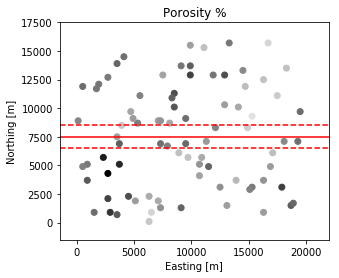

In [3]:
z = zraw  # create copy of raw data

# reduce dataset, plot as 2D
ymean = 7500
yinterval = 2000

fig, ax = subplots()
ax.scatter( z.x, z.y, c=z.por, cmap='gray' )
ax.plot((-1500,22000),(ymean - yinterval / 2, ymean - yinterval / 2), "r--")
ax.plot((-1500,22000),(ymean + yinterval / 2, ymean + yinterval / 2), "r--")
ax.plot((-1500,22000),(ymean, ymean), "r-")
ax.set_aspect(1)
xlim(-1500,22000)
ylim(-1500,17500)
xlabel('Easting [m]')
ylabel('Northing [m]')
title('Porosity %') ;

plt.show()

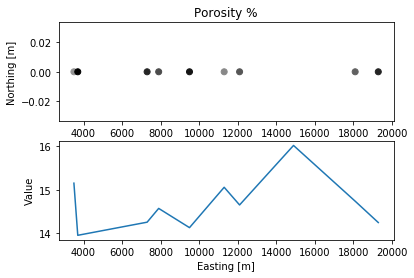

In [4]:
z = z.loc[z.y > ymean - yinterval / 2]
z = z.loc[z.y < ymean + yinterval / 2]

# reduce to quasi 1-D, plot as 1D
z.y = 0.
z = z.sort_values(by="x")

plt.subplot(211)
plt.scatter( z.x, z.y, c=z.por, cmap='gray' )
ylabel('Northing [m]')
title('Porosity %') ;

plt.subplot(212)
plt.plot(z.x, z.por)
ylabel('Value')
xlabel('Easting [m]')
plt.show()

## The Semivariogram

### Theory

The semivariogram encodes data about spatial variance over the region at a given distance or lag. We generally expect data points that are close together spatially to share other characteristics, and we expect points that are separated by greater distances to have lesser correlation. The semivariogram allows us to model the similarity points in a field as a function of distance. The semivariogram is given by,

$$\begin{equation*} \hat{\gamma}(h) = \dfrac{1}{2N(h)} \displaystyle \sum_{N(h)} ( z_{i} - z_{j} )^{2} \end{equation*}$$ (Equation 1)

Here, h is distance specified by the user, and z_{i} and z_{j} are two points that are separated spatially by h. The N(h) term is the number of points we have that are separated by the distance h. The semivariogram then is the sum of squared differences between values separated by a distance h. As an aside, contrast this with the formulation for variance,

$$\begin{equation*} s = \dfrac{1}{N-1} \displaystyle \sum_{k=1}^{N} (z_{k} - \hat{\mu} )^{2} \end{equation*}$$ (Equation 2)

Here, $N$ is the number of data points, $\hat{\mu}$ is the sample mean, and $z_{k}$ is a data point. For sample variance, we are taking the squared difference between data points and the mean, and in the semivariogram we are taking the squared difference between data points separated by distance h. We can write some functions to calculate the semivariogram at one lag, and then at multiple lags as follows.

In [5]:
def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    '''
    pd = squareform( pdist( P[:,:2] ) )
    N = pd.shape[0]
    Z = list()
    for i in range(N):
        for j in range(i+1,N):
            if( pd[i,j] >= h-bw )and( pd[i,j] <= h+bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    return np.sum( Z ) / ( 2.0 * len( Z ) )
 
def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        sv.append( SVh( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T
 
def C( P, h, bw ):
    '''
    Calculate the sill
    '''
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )

The C() function is the covariance function, and will be used later. Let us now calculate and plot the semivariogram,

### Empirical Semivariogram

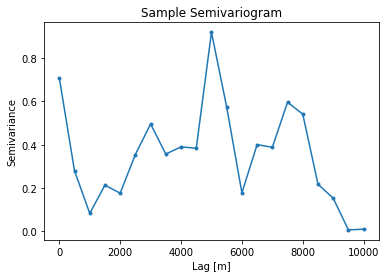

In [6]:
# part of our data set recording porosity
P = np.array( z[['x','y','por']] )
# bandwidth, plus or minus 250 meters
bw = 500
# lags in 500 meter increments from zero to 10,000
hs = np.arange(0,10500,bw)
sv = SV( P, hs, bw )
plot( sv[0], sv[1], '.-' )
xlabel('Lag [m]')
ylabel('Semivariance')
title('Sample Semivariogram') ;
#savefig('sample_semivariogram.png',fmt='png',dpi=200)


### Semivariogram models

Now that we’ve calculated the semivariogram, we will need to fit a model to the data. There are three popular models, the spherical, exponential, and the Gaussian. First, we will present a function named opt() for determining the optimal value a for the spherical model.

In [7]:
def opt( fct, x, y, C0, parameterRange=None, meshSize=1000 ):
    if parameterRange == None:
        parameterRange = [ x[1], x[-1] ]
    mse = np.zeros( meshSize )
    a = np.linspace( parameterRange[0], parameterRange[1], meshSize )
    for i in range( meshSize ):
        mse[i] = np.mean( ( y - fct( x, a[i], C0 ) )**2.0 )
    return a[ mse.argmin() ]

The opt() function finds the optimal parameter for fitting a spherical model to the semivariogram data. The spherical model is given by the function spherical(). On the last line we see that spherical() returns itself in a map() function, which seems odd. The idea is that the input h can be a single float value, or list or NumPy array of floats. If h is a single value, then line 9 is called. If h is a list or an array (an iterable) then line 17 is called, which applies line 9 to each value of h.

In [8]:
import svmodels

In [44]:
def hole_Nnn (h, C0, a, Cn=0):
    #from Triki et al. p.1600 (Dowdall et al. 2003)
    if type(h) == np.float64:
        # calculate the hole function
        if h == 0:
            return Cn
        if h <= pi*a: 
            return (Cn+(C0-Cn)*(1-(sin(h/a ))/(h/a) ))
        else:
            return (Cn+(C0-Cn)*(1-2*(sin(h/a ))/(h/a) ))
    # if h is an iterable
    else:
        # calcualte the hole function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        Cn = np.ones(h.size) * Cn
        return map( hole_Nnn, h, a, C0, Cn )

Next, cvmodel() fits a model to the semivariogram data and returns a covariance method named covfct().

In [45]:
def cvmodel( P, model, hs, bw, Cn=None, svrange=None ):
    '''
    Input:  (P)      ndarray, data
            (model)  modeling function
                      - spherical
                      - exponential
                      - gaussian
            (hs)     distances
            (bw)     bandwidth
    Output: (covfct) function modeling the covariance
    '''
    if Cn is None:
        Cn = N(P, hs, bw)
    # calculate the semivariogram
    sv = SV( P, hs, bw )
    # calculate the sill
    C0 = C( P, hs[0], bw )
    # calculate the optimal parameters
    if svrange is None:
        svrange = opt( model, sv[0], sv[1], C0 )
    # return a covariance function
    covfct = lambda h, a=svrange: C0 - model( h, a, C0, Cn=Cn )
    return covfct

At this point we’ll plot our model and see if it represents our data well.

sill: 0.33, range: 4000.00


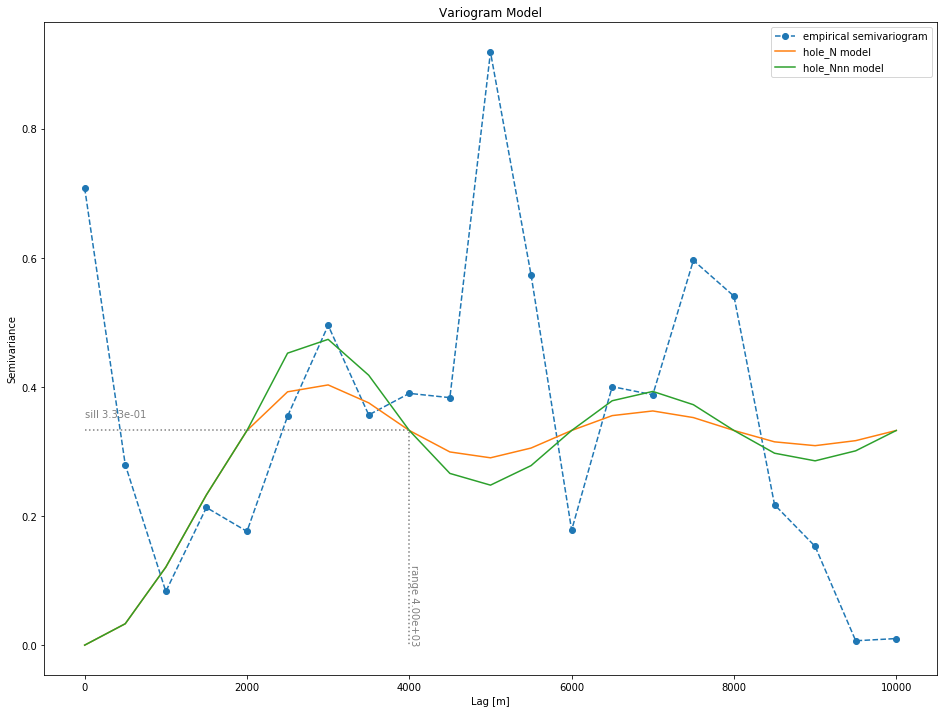

In [46]:
nugget = 0.0 # nugget for all models
rge = 4000  # individual range for all models

cv_gaussian = cvmodel( P, model=svmodels.gaussian, hs=np.arange(0,10500,500), bw=500, Cn=nugget, svrange=rge )
cv_exponential = cvmodel( P, model=svmodels.exponential, hs=np.arange(0,10500,500), bw=500, Cn=nugget, svrange=rge )
cv_spherical = cvmodel( P, model=svmodels.spherical, hs=np.arange(0,10500,500), bw=500, Cn=nugget, svrange=rge )
cv_hole = cvmodel( P, model=svmodels.hole, hs=np.arange(0,10500,500), bw=500, Cn=nugget, svrange=rge )
cv_hole_N = cvmodel( P, model=svmodels.hole_N, hs=np.arange(0,10500,500), bw=500,Cn=nugget, svrange=rge/(2*pi) )
cv_hole_Nnn = cvmodel( P, model=hole_Nnn, hs=np.arange(0,10500,500), bw=500,Cn=nugget, svrange=rge/(2*pi) )


C0 = C( P, hs[0], bw )  # Sill
#C0 = 0.8

title('Variogram Model')
plot(sv[0], sv[1], 'o--', label="empirical semivariogram")
#plot(sv[0], C0 - cv_gaussian( sv[0] ), label="gaussian model" )
#plot(sv[0], C0 - cv_exponential( sv[0] ), label="exponential model" )
#plot(sv[0], C0 - cv_spherical( sv[0] ), label="spherical model" )
#plot(sv[0], C0 - cv_hole( sv[0] ), label="hole model" )
plot(sv[0], C0 - cv_hole_N( sv[0] ), label="hole_N model" )
plot(sv[0], C0 - cv_hole_Nnn( sv[0] ), label="hole_Nnn model" )
ylabel('Semivariance')
xlabel('Lag [m]')
plt.legend()
#savefig('semivariogram_model.png',fmt='png',dpi=200)

sp = cv_hole_Nnn  # choose here the covariance function with which kriging is performed later

sv = SV( P, hs=np.arange(0,10500,500), bw=500 )

#a = opt( svmodels.gaussian, sv[0], sv[1], C0 )  # range
svrange=rge
a=svrange
plt.plot((0,a,a),(C0,C0,0), ":", c="grey")
plt.text(0,C0+0.02,"sill {:.2e}".format(C0),color="grey")
plt.text(a,0,"range {:.2e}".format(a), rotation=270, verticalalignment='bottom',color="grey")

print("sill: {:.2f}, range: {:.2f}".format(C0,a))

## Simple Kriging


Now that we have a model for the semivariogram, we can write a function to perform the kriging. The fundamental relationship is a matrix equation,

$$\begin{equation*} K \lambda = k \Rightarrow \lambda = K^{-1} k \end{equation*} $$ 

Here, $K$ is a matrix of covariances calculated using the spherical model, $\lambda$ is a vector of simple kriging weights, and $k$ is the vector of covariances between the data points and an unsampled point. Our kriging function takes the data set $P$, the model, the distances hs, the bandwidth bw, the coordinates of the unsampled point u, and the number of surrounding points N to use in the calculation.

### Estimation (the actual Kriging process)

Here, we’ll calculate the kriging estimate at a number of unsampled points. We create a linear vector of x-values, and then make a prediction of the value for each of them. 

In [47]:
def krige( P, covfct, u, N ):
    '''
    Input  (P)     ndarray, data
           (covfct) modeling function
                    - spherical
                    - exponential
                    - gaussian
           (u)     unsampled point
           (N)     number of neighboring
                   points to consider
    '''

    assert N < len(P) + 1, "Number of Neighbors greater than number of data points"
 
    # distance between u and each data point in P
    d = np.sqrt( ( P[:,0]-u[0] )**2.0 + ( P[:,1]-u[1] )**2.0 )
    # add these distances to P
    P = np.vstack(( P.T, d )).T
    # sort P by these distances
    # take the first N of them
    P_n = P[d.argsort()[:N]]
 
    # apply the covariance model to the distances
    k = covfct( P_n[:,3] )
    # cast as a matrix
    k = np.matrix( k ).T
 
    # form a matrix of distances between existing data points
    K = squareform( pdist( P_n[:,:2] ) )
    # apply the covariance model to these distances
    K = covfct( K.ravel() )
    # re-cast as a NumPy array -- thanks M.L.
    K = np.array( K )
    # reshape into an array
    K = K.reshape(N,N)
    # cast as a matrix
    K = np.matrix( K )
    
    # Introducing the LaGrange Factor
    K_1 = np.hstack([K, np.ones((K.shape[0],1))])
    K_2 = np.hstack([np.ones((1, K.shape[0])),np.zeros((1,1))])
    K = np.vstack([K_1, K_2])
    K = np.identity(6)*0.1+K
    k = np.vstack([k,1])

    # calculate the kriging weights
    weights = np.linalg.inv( K ) * k
    weights = np.array( weights )
    lagrange = weights[-1]
    weights = weights[:-1]  

    # calculate the residuals
    o = P_n[:,2]
 
    # calculate the estimation
    estimation = np.dot( weights.T, o )
    
    return (float( estimation ), k[:-1], K[:-1,:-1], weights, P_n, lagrange)

In [48]:
# Define the intervall 

X0, X1 = 0., 25000.  # min X, max X
n = 1000  # number of samples
nn = 5  # number of neighbors for Kriging

dx = (X1-X0)/n
print("sampling resolution: {:.2f}".format(dx))

# create progress indicator
from ipywidgets import FloatProgress
from IPython.display import display
wdgt = FloatProgress(min=0, max=n, description="Running Kriging ... ")
display(wdgt)
      
      
# perform Krigin
Z = np.zeros(n)
V = np.zeros(n)
L = np.zeros(n)
M = np.zeros(n)
for i in range(n):
    wdgt.value += 1
    h, k, K, weights, P_n, lagrange = krige( P, sp, (dx*i, 0), nn )
    Z[i] = h
    v = C0 - np.dot(k.T, weights)
    V[i] = max(v,0)  # computation accuracy may lead to small negative variance
    L[i] = lagrange
    M[i] =  P_n[:,2].mean()

sampling resolution: 25.00


FloatProgress(value=0.0, description=u'Running Kriging ... ', max=1000.0)

## Plotting the Estimator - 1D

### Estimate and Uncertainty




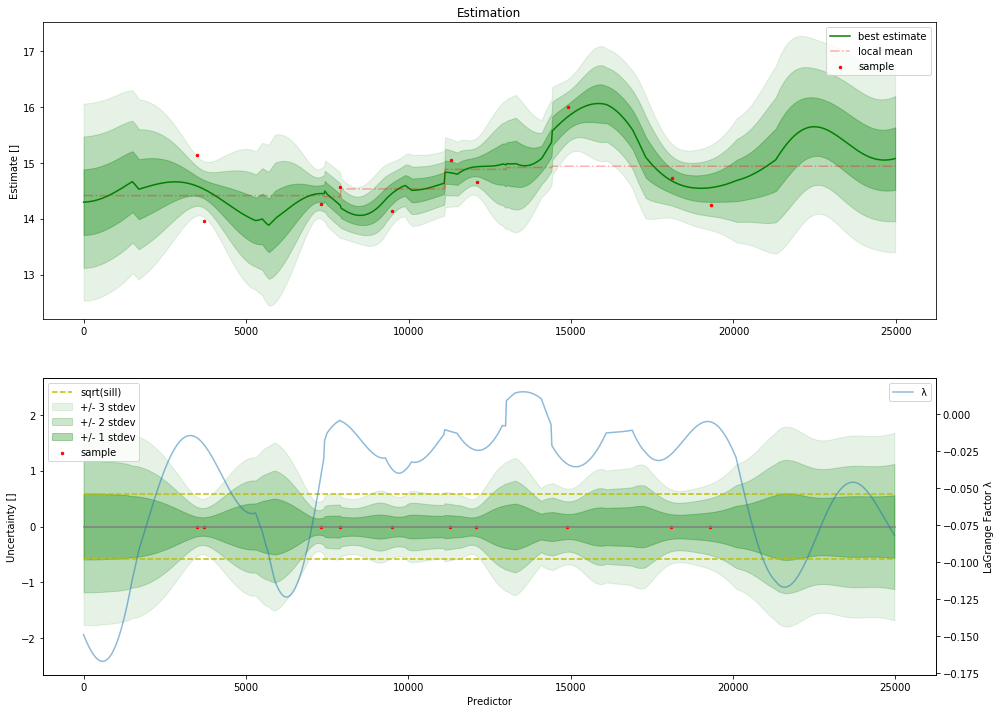

In [49]:
plt.rcParams["figure.figsize"] = (16, 12)

X = [i*dx for i in range(n)]

ax1 = plt.subplot(211)
plt.title("Estimation")
ax1.fill_between(X, Z-3*np.sqrt(V), Z+3*np.sqrt(V), color='green', alpha=0.1)#, label="+/- 3 stdev")
ax1.fill_between(X, Z-2*np.sqrt(V), Z+2*np.sqrt(V), color='green', alpha=0.2)#, label="+/- 2 stdev")
ax1.fill_between(X, Z-1*np.sqrt(V), Z+1*np.sqrt(V), color='green', alpha=0.3)#, label="+/- 1 stdev")
ax1.plot(X, Z, "g-", label="best estimate")
ax1.scatter(z.x, z.por, s=6, c="r", label="sample")
ax1.plot(X, M, "r-.", alpha=0.3, label="local mean")
ax1.set_ylabel('Estimate []')
plt.legend(loc='upper right')
lim = ax1.get_ylim()

ax2 = plt.subplot(212)
ax2.fill_between(X, 3*np.sqrt(V), -3*np.sqrt(V), color='green', alpha=0.1, label="+/- 3 stdev")
ax2.fill_between(X, 2*np.sqrt(V), -2*np.sqrt(V), color='green', alpha=0.2, label="+/- 2 stdev")
ax2.fill_between(X, 1*np.sqrt(V), -1*np.sqrt(V), color='green', alpha=0.3, label="+/- 1 stdev")
ax2.plot((X0, X1),(1*np.sqrt(C0), 1*np.sqrt(C0)), "y--", label="sqrt(sill)")
ax2.plot((X0, X1),(0,0), "grey")
ax2.plot((X0, X1),(-1*np.sqrt(C0), -1*np.sqrt(C0)), "y--")
ax2.set_ylim(lim - (lim[0] + lim[1])/2)  # set variance y-scale equal to value, but centered to zero
ax2.scatter(z.x, np.zeros_like(z.x), s=6, c="r", label="sample")
xlabel('Predictor')
ylabel('Uncertainty []')
plt.legend(loc='upper left')

ax2_2 = ax2.twinx()
ax2_2.plot(X, L, label=u"λ", alpha=0.5)
plt.legend(loc='upper right')
ylabel(u'LaGrange Factor λ')
plt.savefig("gaussian_krigin1d-withNugget.png")
_ = plt.show()


## Kriging Weights Analysis

Use the sliders to change the X-Coordinate of the sampled point and the number of neighbors considered in Kriging.
Note: The background curves are not updated (computed with the original value of {{nn}} neighbors)

In [15]:
sys.exit()

SystemExit: 

C:\Users\jomz\AppData\Local\conda\conda\envs\ipykernel_py2\lib\site-packages\IPython\core\interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
%matplotlib notebook
#plt.rcParams['font.size'] = 12
#plt.rcParams['figure.figsize'] = [16 / 1.5, 10 / 1.5]   # inch / cm = 2.54

from ipywidgets import *

fig = plt.figure()

def drawfig(fig, x, nn):
    
    u = (x, 0)  # (x,y) - coordinates of unsampled points

    ax = fig.add_subplot(1, 1, 1)

    #plt.fill_between([i*dx for i in range(n)], Z-2*np.sqrt(V), Z+3*np.sqrt(V), color='green', alpha=0.1, label="+/- 3 stdev")
    ax.fill_between([i*dx for i in range(n)], Z-2*np.sqrt(V), Z+2*np.sqrt(V), color='green', alpha=0.2, label="+/- 2 stdev")
    ax.fill_between([i*dx for i in range(n)], Z-1*np.sqrt(V), Z+1*np.sqrt(V), color='green', alpha=0.3, label="+/- 1 stdev")
    ax.plot([i*dx for i in range(n)], Z, "g-", label="estimator")
    ax.scatter(z.x, z.por, s=6, c="r", label="sample")
    ax.plot(X, M, "r-.", alpha=0.3, label="local mean")
    
    #ax.legend(loc='upper right')

    estimation, k, K, weights, P_n, lagrange = krige( P, sp, u, nn )
    variance = max(C0 - np.dot( weights.T, k ),0)
    

    ax.plot(z.x, z.por, 
             "o--", label="samples")
    ax.scatter((x), (estimation), 
                c="red", label="estimate")
    ax.errorbar((u[0]), (estimation), yerr = sqrt(float(variance)), 
                 fmt="r", label="standard deviation")

    offset = 0.05
    for i in range(len(weights)):
        ax.text(P_n[i,0]+offset, 
                P_n[i,2]+offset, 
                "{:.2f}".format(float(weights[i])),
                color="black")
    
    ax2_2 = ax.twinx()
    ax2_2.plot(X, L, label=u"λ", alpha=0.5)
    plt.legend(loc='upper right')
    ylabel(u'LaGrange Factor λ')

    
drawfig(fig, 6000, nn)

minx = P[:,0].min() - 2*a
maxx = P[:,0].max() + 2*a

@interact(x=(minx, maxx), nn=(1,len(P)))
def updatefig(x, nn):
    fig.clear()
    drawfig(fig, x, nn)
